# [Interval Competition: House Prices](https://www.kaggle.com/competitions/prediction-interval-competition-ii-house-price)

## Описание
Как уже упоминалось, в регрессионном анализе нередко фокусируются на так называемых точечных прогнозах (отражающих центральную тенденцию). Однако в этом соревновании нас интересует создание интервала прогнозирования (отражающего дисперсию).

Наша задача — создать регрессионную модель с самыми узкими (наиболее «эффективными») общими интервалами прогнозирования

## Оценка
Мы оценим общую эффективность нашей модели, используя среднее значение показателя интервала Винклера, которое для отдельного интервала определяется следующим образом:

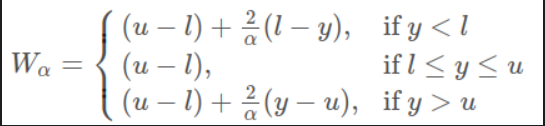

где 
 это истинная ценность, 
 это верхний предел прогнозного интервала, 
 это нижний предел прогнозного интервала, и 
 Это (100-процентное покрытие)/100.

Покрытие
В этом соревновании целью является номинальное предельное покрытие в 90% (т.е. 
). То есть 90% интервалов прогнозирования содержат истинное значение (y_true).

________________________________________________________________________________________________________________________________________________________

# Ипопрт необходимых библиотек

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats
from scipy.stats import norm
from sklearn.cluster import KMeans
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

# Data Engineering

## Удалим столбцы в которых есть пропущенные значения и назначение индексируемого столбца

In [50]:
def clearing_missing_values(df):
    print("Начало работы функции clearing_missing_values")
    kol_mistakes = df.isnull().sum()
    columns_with_mistakes = df.isnull().sum()[kol_mistakes > 0]
    drop_feature = columns_with_mistakes.index.tolist()
    df = df.drop(columns=drop_feature)

    assert df['id'].is_unique 
    df = df.set_index('id')
    return df


## Из числовых признаков формируем пары для выявления нелинейных зависимостей

In [51]:
def create_peirs_of_feature(df):
    print("Начало работы функции create_peirs_of_feature")

    from itertools import combinations

    important_nums = list(set([
        'area', 'sqft', 'land_val', 'imp_val', 'grade', 'beds',
        'bath_full', 'sqft_lot', 'sqft_1', 'sqft_fbsmt',
        'garb_sqft', 'gara_sqft'
    ]))
    
    

    for f1, f2 in combinations(important_nums, 2):
        col_name = f"{f1}_x_{f2}"
        df[col_name] = df[f1] * df[f2]

    return df

## Создадим данные связанные со временем, для выявления временных зависимостей

In [52]:
def add_date_features(df):
    print("Начало работы функции add_date_features")
    df['sale_date'] = pd.to_datetime(df['sale_date'], errors='coerce')

    df['sale_year'] = df['sale_date'].dt.year
    df['sale_month'] = df['sale_date'].dt.month

    df['month_sin'] = np.sin(2 * np.pi * df['sale_month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['sale_month'] / 12)

    df['house_age'] = df['sale_year'] - df['year_built']

    df['renovated'] = (df['year_reno'] > 0).astype(int)

    df['years_since_renovation'] = np.where(
        df['year_reno'] > 0,
        df['sale_year'] - df['year_reno'],
        df['house_age']  
    )
    
    df.drop(columns=['sale_date'], inplace=True)

    return df

## Добавим еще различные полезные фичи

In [53]:
def new_features(df):
    print("Начало работы функции new_features")
    df['total_bath'] = df['bath_full'] + 0.75 * df['bath_3qtr'] + 0.5 * df['bath_half']
    df['total_view'] = df[[c for c in df.columns if 'view_' in c]].sum(axis=1)

    df['lot_utilization'] = df['sqft'] / df['sqft_lot']
    df['garage_ratio'] = df['gara_sqft'] / (df['sqft'] + 1e-3)
    df['bath_bed_ratio'] = df['total_bath'] / (df['beds'] + 1e-3)

    df['structure_share'] = df['imp_val'] / (df['imp_val'] + df['land_val'] + 1e-3)

    df['has_basement'] = (df['sqft_fbsmt'] > 0).astype(int)
    df['has_garage'] = (df['gara_sqft'] > 0).astype(int)
    df['was_renovated'] = (df['year_reno'] > 0).astype(int)
    df['has_view'] = (df['total_view'] > 0).astype(int)

    df['condition_grade'] = df['condition'] * df['grade']

    df['total_area'] = df['sqft'] + df['sqft_fbsmt'] + df['gara_sqft']

    df = df[df['total_area'] / (df['beds']+1e-3) > 300]

    return df


## Логарифмирование больших значений

In [54]:
def log_transform_features(df, flag_train = False):
    print("Начало работы функции log_transform_features")
    if flag_train:
        log_candidates = [
            'grade_x_land_val', 'grade_x_sqft_lot', 'grade_x_sqft', 'grade_x_sqft_fbsmt', 'grade_x_gara_sqft',
            'grade_x_imp_val', 'beds_x_land_val', 'beds_x_sqft_lot', 'beds_x_sqft', 'beds_x_sqft_fbsmt',
            'beds_x_gara_sqft', 'beds_x_imp_val', 'garb_sqft_x_land_val', 'garb_sqft_x_sqft_lot',
            'garb_sqft_x_sqft', 'garb_sqft_x_sqft_fbsmt', 'garb_sqft_x_gara_sqft', 'garb_sqft_x_imp_val',
            'sqft_1_x_land_val', 'sqft_1_x_sqft_lot', 'sqft_1_x_sqft', 'sqft_1_x_sqft_fbsmt', 'sqft_1_x_gara_sqft',
            'sqft_1_x_imp_val', 'area_x_land_val', 'area_x_sqft_lot', 'area_x_sqft', 'area_x_sqft_fbsmt',
            'area_x_gara_sqft', 'area_x_imp_val', 'land_val_x_sqft_lot', 'land_val_x_sqft',
            'land_val_x_sqft_fbsmt', 'land_val_x_gara_sqft', 'land_val_x_imp_val', 'sqft_lot_x_sqft',
            'sqft_lot_x_sqft_fbsmt', 'sqft_lot_x_gara_sqft', 'sqft_lot_x_imp_val', 'bath_full_x_sqft',
            'bath_full_x_sqft_fbsmt', 'bath_full_x_gara_sqft', 'bath_full_x_imp_val', 'sqft_x_sqft_fbsmt',
            'sqft_x_gara_sqft', 'sqft_x_imp_val', 'sqft_fbsmt_x_gara_sqft', 'sqft_fbsmt_x_imp_val',
            'gara_sqft_x_imp_val', 'sale_price', 'land_val', 'imp_val', 'sqft_lot',
            'price_per_sqft', 'total_area'
        ]
    else:
        log_candidates = [
            'grade_x_land_val', 'grade_x_sqft_lot', 'grade_x_sqft', 'grade_x_sqft_fbsmt', 'grade_x_gara_sqft',
            'grade_x_imp_val', 'beds_x_land_val', 'beds_x_sqft_lot', 'beds_x_sqft', 'beds_x_sqft_fbsmt',
            'beds_x_gara_sqft', 'beds_x_imp_val', 'garb_sqft_x_land_val', 'garb_sqft_x_sqft_lot',
            'garb_sqft_x_sqft', 'garb_sqft_x_sqft_fbsmt', 'garb_sqft_x_gara_sqft', 'garb_sqft_x_imp_val',
            'sqft_1_x_land_val', 'sqft_1_x_sqft_lot', 'sqft_1_x_sqft', 'sqft_1_x_sqft_fbsmt', 'sqft_1_x_gara_sqft',
            'sqft_1_x_imp_val', 'area_x_land_val', 'area_x_sqft_lot', 'area_x_sqft', 'area_x_sqft_fbsmt',
            'area_x_gara_sqft', 'area_x_imp_val', 'land_val_x_sqft_lot', 'land_val_x_sqft',
            'land_val_x_sqft_fbsmt', 'land_val_x_gara_sqft', 'land_val_x_imp_val', 'sqft_lot_x_sqft',
            'sqft_lot_x_sqft_fbsmt', 'sqft_lot_x_gara_sqft', 'sqft_lot_x_imp_val', 'bath_full_x_sqft',
            'bath_full_x_sqft_fbsmt', 'bath_full_x_gara_sqft', 'bath_full_x_imp_val', 'sqft_x_sqft_fbsmt',
            'sqft_x_gara_sqft', 'sqft_x_imp_val', 'sqft_fbsmt_x_gara_sqft', 'sqft_fbsmt_x_imp_val',
            'gara_sqft_x_imp_val', 'land_val', 'imp_val', 'sqft_lot',
            'price_per_sqft', 'total_area'
        ]

    for col in log_candidates:
        if col in df.columns:
            df[col] = np.log1p(df[col])
            
    return df


## Удалим выбросы

In [55]:
def remove_outliers_iqr(df, columns=None, factor=3, verbose=True):
    print("Начало работы функции remove_outliers_iqr")
 
    df_clean = df.copy()
    if columns is None:
        columns = df.select_dtypes(include=[np.number]).columns

    mask = pd.Series(True, index=df.index)
    for col in columns:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - factor * iqr
        upper = q3 + factor * iqr
        mask &= df[col].between(lower, upper)

    if verbose:
        removed = (~mask).sum()
        print(f"Удалено {removed} строк с выбросами из {len(df)}")

    return df_clean[mask]


## Добавим агригированные признаки

In [56]:
def add_statistical_aggregates_safe(df_train, df_test, target='sale_price', top_n=20):
    print("Начало работы функции add_statistical_aggregates_safe")

    # 1. Категориальные признаки с малым числом уникальных значений
    cat_cols = [c for c in df_train.columns if df_train[c].nunique() < 100 
                and c != target and df_train[c].dtype == 'object']

    # 2. Топ-N числовых по корреляции с целевым
    num_cols = df_train.select_dtypes(include=[np.number]).columns.drop(target)
    corr = df_train[num_cols].corrwith(df_train[target]).abs()
    top_num_cols = corr.sort_values(ascending=False).head(top_n).index.tolist()

    # 3. Агрегации
    stats = [
        ('min', 'min'),
        ('mean', 'mean'),
        ('std', 'std'),
        ('median', 'median'),
        ('skew', scipy.stats.skew),
        ('ptp', lambda x: np.ptp(x)),
        ('q30', lambda x: np.percentile(x.dropna(), 30)),
        ('q70', lambda x: np.percentile(x.dropna(), 70)),
        ('nunique/count', lambda x: x.nunique() / (len(x) + 1e-3)),
        ('mean/std', lambda x: np.mean(x) / (np.std(x) + 1e-3)),
    ]

    df_train_new = df_train.copy()
    df_test_new = df_test.copy()

    for cat in cat_cols:
        for num in top_num_cols:
            print(f"Группировка: {cat} → {num}")
            funcs = [f for _, f in stats]
            names = [n for n, _ in stats]

            # группируем по train
            grouped = df_train.groupby(cat)[num].agg(funcs)
            grouped.columns = [f'{cat}_{num}_{n}' for n in names]

            # мержим в train и test
            df_train_new = df_train_new.merge(grouped, how='left', left_on=cat, right_index=True)
            df_test_new = df_test_new.merge(grouped, how='left', left_on=cat, right_index=True)

    return df_train_new, df_test_new


## На основе координат сделаем кластеры использую Kmeans

In [57]:
def fit_location_clusters(train_df, test_df, n_clusters=20, random_state=42):
    print("Начало работы функции fit_location_clusters")
    coords = train_df[['latitude', 'longitude']]
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
    kmeans.fit(coords)

    train_df = train_df.copy()
    test_df = test_df.copy()

    train_df['location_cluster'] = kmeans.predict(train_df[['latitude', 'longitude']])
    test_df['location_cluster'] = kmeans.predict(test_df[['latitude', 'longitude']])

    return train_df, test_df

## Разбиение данных на валидационную и тренировочную выборку

In [58]:
def select_data(df_train, target_col='sale_price', test_size=0.2, random_state=42):
    print("Начало работы функции select_data")
    X = df_train.drop(columns=[target_col])
    y = df_train[target_col]
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=random_state)
    return X_train, y_train, X_val, y_val

## Target encoding для сатегориальных признаков

In [59]:
def target_encode_all(
    train_df: pd.DataFrame,
    val_df:   pd.DataFrame,
    test_df:  pd.DataFrame,
    target_col: str = "sale_price",
    n_splits: int = 5,
):
    """Кросс-валидационный target-encoding + безопасное выравнивание."""

    print("Начало работы функции target_encode_all")
    print(f"Размеры train_df: {train_df.shape}, val_df: {val_df.shape}, test_df: {test_df.shape}")

    # 0. Категориальные признаки
    cat_cols = [
        c for c in train_df.columns
        if train_df[c].dtype == "object" and c != target_col
    ]
    overall_mean = train_df[target_col].mean()

    # 1. Сброс индекса → позиции гарантированно 0..N-1
    train_df = train_df.reset_index(drop=True)
    val_df   = val_df.reset_index(drop=True)
    test_df  = test_df.reset_index(drop=True)
    print(f"Размеры после сброса индекса: train_df: {train_df.shape}, val_df: {val_df.shape}, test_df: {test_df.shape}")
    
    train_enc = train_df.copy()
    val_enc   = val_df.copy()
    test_enc  = test_df.copy()
    print(f"До обработки: {len(train_enc)}")

    # 2. OOF-encoding по каждому категориальному признаку
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    i = 0
    for col in cat_cols:
        i += 1
        print(f"Итерация номер-{i} длина: {len(train_enc)}")
        oof = np.full(len(train_df), np.nan, dtype=np.float32)

        for tr_idx, va_idx in kf.split(train_df):
            fold_mean = (
                train_df.iloc[tr_idx]
                .groupby(col)[target_col]
                .mean()
            )
            oof[va_idx] = (
                train_df.iloc[va_idx][col]
                .map(fold_mean)
                .fillna(overall_mean)
                .to_numpy()
            )

        # 👉 присваиваем по ПОЛОЖЕНИЯМ, не по индексу
        train_enc[f"{col}_te"] = oof

        full_mean = train_df.groupby(col)[target_col].mean()
        val_enc[f"{col}_te"]  = val_df[col].map(full_mean).fillna(overall_mean)
        test_enc[f"{col}_te"] = test_df[col].map(full_mean).fillna(overall_mean)
    
    print(f"После обработки: {len(train_enc)}")

    # 3. Удаляем «сырые» категориальные столбцы
    train_enc.drop(columns=cat_cols, inplace=True)
    val_enc.drop(columns=cat_cols, inplace=True)
    test_enc.drop(columns=cat_cols, inplace=True)
    print(f"После удаления категориальных столбцов: {len(train_enc)}")
    

    # 4. Удаляем таргет из train_enc
    train_enc = train_enc.drop(columns=[target_col], errors="ignore")
    print(f"После удаления таргета: {len(train_enc)}")

    # 5. Контроль целостности
    assert len(train_enc) == len(train_df), "‼️ Rows duplicated in train_enc"
    assert len(val_enc)   == len(val_df),  "‼️ Rows duplicated in val_enc"
    assert len(test_enc)  == len(test_df), "‼️ Rows duplicated in test_enc"

    return train_enc, val_enc, test_enc

## ETL процессы

In [60]:
def Explore():
    print("Начало работы функции Explore")
    df_train = pd.read_csv('data/dataset.csv')
    df_test = pd.read_csv('data/test.csv')
    return df_train, df_test

In [ ]:
def Transform(df_train, df_test):
    print("Начало работы функции Transform")
    print("Начало обработки train")
    df_train = clearing_missing_values(df_train)
    df_train = create_peirs_of_feature(df_train)
    df_train = add_date_features(df_train)
    df_train = new_features(df_train)
    df_train = log_transform_features(df_train, True)
    df_train = remove_outliers_iqr(df_train, factor=40)

    print("Начало обработки test")
    df_test = clearing_missing_values(df_test)
    df_test = create_peirs_of_feature(df_test)
    df_test = add_date_features(df_test)
    df_test = new_features(df_test)
    df_test = log_transform_features(df_test)

    print("Начало работы с train и test")
    df_train, df_test = fit_location_clusters(df_train, df_test)
    df_train, df_test = add_statistical_aggregates_safe(df_train, df_test)

    df_train_X, df_train_Y, df_validation_X, df_validation_Y = select_data(df_train)

    print(f"train: {len(df_train_X.columns.tolist())}  test: {len(df_test.columns.tolist())}")
    print("X_train:", df_train_X.shape)
    print("y_train:", df_train_Y.shape)
    print("X_val:",   df_validation_X.shape)
    print("y_val:",   df_validation_Y.shape)

    df_train_X, df_validation_X, df_test = target_encode_all(pd.concat([df_train_X, df_train_Y], axis=1), df_validation_X, df_test)
    print("X_train:", df_train_X.shape)
    print("y_train:", df_train_Y.shape)
    print("X_val:",   df_validation_X.shape)
    print("y_val:",   df_validation_Y.shape)

    print("Обработка завершена")

    return df_train_X, df_train_Y, df_validation_X, df_validation_Y, df_test

In [62]:
def Load(df_train_X, df_train_Y, df_validation_X, df_validation_Y, df_test):
    print("Начало работы функции Load")
    df_train_X.to_csv('data/after_processing/train_X.csv', index=False)
    df_train_Y.to_csv('data/after_processing/train_Y.csv', index=False)
    df_validation_X.to_csv('data/after_processing/validation_X.csv', index=False)
    df_validation_Y.to_csv('data/after_processing/validation_Y.csv', index=False)
    df_test.to_csv('data/after_processing/test.csv', index=False)

    

In [63]:
def ETL():
    print("Начало работы функции ETL")
    df_train, df_test = Explore()
    df_train_X, df_train_Y, df_validation_X, df_validation_Y, df_test = Transform(df_train, df_test)
    Load(df_train_X, df_train_Y, df_validation_X, df_validation_Y, df_test)
    print("ETL завершен")

In [64]:
ETL()

Начало работы функции ETL
Начало работы функции Explore
Начало работы функции Transform
Начало обработки train
Начало работы функции clearing_missing_values
Начало работы функции create_peirs_of_feature
Начало работы функции add_date_features
Начало работы функции new_features
Начало работы функции log_transform_features
Начало работы функции remove_outliers_iqr
Удалено 105844 строк с выбросами из 198755
Начало обработки test
Начало работы функции clearing_missing_values
Начало работы функции create_peirs_of_feature
Начало работы функции add_date_features
Начало работы функции new_features
Начало работы функции log_transform_features
Начало работы с train и test
Начало работы функции fit_location_clusters
Начало работы функции add_statistical_aggregates_safe


c:\Users\Alexey\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Alexey\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Группировка: sale_warning → sale_year


c:\Users\Alexey\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\groupby\generic.py:324: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  f = lambda x: func(x, *args, **kwargs)


Группировка: sale_warning → sqft_x_grade
Группировка: sale_warning → sqft
Группировка: sale_warning → grade


c:\Users\Alexey\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\groupby\generic.py:324: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  f = lambda x: func(x, *args, **kwargs)


Группировка: sale_warning → imp_val_x_grade
Группировка: sale_warning → imp_val_x_beds
Группировка: sale_warning → total_area
Группировка: sale_warning → sqft_x_beds
Группировка: sale_warning → land_val_x_grade
Группировка: sale_warning → beds_x_grade


c:\Users\Alexey\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\groupby\generic.py:324: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  f = lambda x: func(x, *args, **kwargs)


KeyboardInterrupt: 

# Обучение модели

## Загрузка обработанных датасетов

In [ ]:
df_train_X = pd.read_csv('data/after_processing/train_X.csv')
df_train_Y = pd.read_csv('data/after_processing/train_Y.csv')
df_validation_X = pd.read_csv('data/after_processing/validation_X.csv')
df_validation_Y = pd.read_csv('data/after_processing/validation_Y.csv')
df_test = pd.read_csv('data/after_processing/test.csv')

In [ ]:
print("X_train:", df_train_X.shape)
print("y_train:", df_train_Y.shape)
print("X_val:",   df_validation_X.shape)
print("y_val:",   df_validation_Y.shape)

X_train: (198755, 527)
y_train: (159004, 1)
X_val: (39751, 527)
y_val: (39751, 1)


## Гиперпараметры моделей

In [ ]:
MEAN_PARAMS = dict(
    n_estimators=4000, learning_rate=0.03, num_leaves=256,
    subsample=0.9, colsample_bytree=0.9, objective="regression",
    random_state=42,
)
SIGMA_PARAMS = dict(
    n_estimators=3000, learning_rate=0.05, num_leaves=128,
    subsample=0.9, colsample_bytree=0.9, objective="regression",
    random_state=43,
)
ALPHA = 0.10             # 90 % интервал

## Обучающая функция

In [ ]:
def fit_mean_sigma(X_tr, y_tr, X_val, y_val):
    """Обучает две модели LightGBM и возвращает (mean_model, sigma_model)."""
    mean_model = lgb.LGBMRegressor(**MEAN_PARAMS)
    mean_model.fit(
        X_tr, y_tr,
        eval_set=[(X_val, y_val)],
        eval_metric="l1",
        callbacks=[lgb.early_stopping(200), lgb.log_evaluation(100)],
    )
    resid_tr  = np.abs(y_tr - mean_model.predict(X_tr, num_iteration=mean_model.best_iteration_))
    resid_val = np.abs(y_val - mean_model.predict(X_val, num_iteration=mean_model.best_iteration_))
    sigma_model = lgb.LGBMRegressor(**SIGMA_PARAMS)
    sigma_model.fit(
        X_tr, resid_tr,
        eval_set=[(X_val, resid_val)],
        eval_metric="l1",
        callbacks=[lgb.early_stopping(150), lgb.log_evaluation(100)],
    )
    return mean_model, sigma_model

## Функция для вычисления loss 

In [ ]:
def winkler_score(y, l, u, alpha=ALPHA):
    width = u - l
    penalty_l = 2/alpha * (l - y) * (y < l)
    penalty_u = 2/alpha * (y - u) * (y > u)
    return np.mean(width + penalty_l + penalty_u)

## Обучение

In [ ]:
mean_model, sigma_model = fit_mean_sigma(
    df_train_X, df_train_Y, df_validation_X, df_validation_Y
)

LightGBMError: Length of labels differs from the length of #data

## Валидация

In [ ]:
z_values, winklers, coverages = [], [], []

for z in np.linspace(1.5, 2.0, 30):
    mu_val = mean_model.predict(df_validation_X, num_iteration=mean_model.best_iteration_)
    sigma_val = sigma_model.predict(df_validation_X, num_iteration=sigma_model.best_iteration_)
    lower = mu_val - z * sigma_val
    upper = mu_val + z * sigma_val

    winkler = winkler_score(df_validation_Y.values, lower, upper)
    coverage = ((df_validation_Y.values >= lower) & (df_validation_Y.values <= upper)).mean()

    z_values.append(z)
    winklers.append(winkler)
    coverages.append(coverage)

In [ ]:
plt.plot(z_values, winklers, label='Winkler Score')
plt.plot(z_values, coverages, label='Coverage')
plt.axhline(0.90, color='red', linestyle='--', label='Target coverage 90%')
plt.legend()
plt.xlabel("z")
plt.title("Зависимость Winkler/Покрытия от z")
plt.show()

## Предсказание на тесте и submit

In [ ]:
mu_test    = mean_model.predict(df_test,  num_iteration=mean_model.best_iteration_)
sigma_test = sigma_model.predict(df_test, num_iteration=sigma_model.best_iteration_)
submission = pd.DataFrame({
    "Id":               df_test.index,
    "SalePrice_Lower":  mu_test - Z * sigma_test,
    "SalePrice_Pred":   mu_test,
    "SalePrice_Upper":  mu_test + Z * sigma_test,
})
submission.to_csv("submission.csv", index=False)
print("submission.csv готов! ✅")

## Сохранение моделей

In [ ]:
mean_model.booster_.save_model("model\mean_model.lgb")
sigma_model.booster_.save_model("model\sigma_model.lgb")